In [1]:
!pip install wget

In [0]:
import os
import re
from pathlib import Path
from nltk.tokenize import RegexpTokenizer
from collections import Counter
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.exceptions import ConvergenceWarning
import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import random
import wget
random.seed()
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [3]:
filename = wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/20_newsgroups.zip", "20_newsgroups.zip")
!unzip 20_newsgroups.zip
DATA_DIR = "20_newsgroups"

Streaming output truncated to the last 5000 lines.
  inflating: 20_newsgroups/sci.electronics/53948  
  inflating: 20_newsgroups/sci.electronics/54351  
  inflating: 20_newsgroups/talk.politics.guns/54118  
  inflating: 20_newsgroups/talk.politics.guns/54588  
  inflating: 20_newsgroups/talk.politics.guns/54127  
  inflating: 20_newsgroups/talk.politics.guns/53302  
  inflating: 20_newsgroups/talk.politics.guns/54315  
  inflating: 20_newsgroups/talk.politics.guns/54771  
  inflating: 20_newsgroups/talk.politics.guns/54543  
  inflating: 20_newsgroups/talk.politics.guns/55233  
  inflating: 20_newsgroups/talk.politics.guns/55039  
  inflating: 20_newsgroups/talk.politics.guns/54749  
  inflating: 20_newsgroups/talk.politics.guns/55234  
  inflating: 20_newsgroups/talk.politics.guns/54782  
  inflating: 20_newsgroups/talk.politics.guns/54544  
  inflating: 20_newsgroups/talk.politics.guns/54312  
  inflating: 20_newsgroups/talk.politics.guns/54120  
  inflating: 20_newsgroups/talk.polit

## Functions from lab

In [0]:
def clean_file_text(text):
    new_text = re.sub("Newsgroups:.*?\n", "", text)
    new_text = re.sub("Xref:.*?\n", "", new_text)
    new_text = re.sub("Path:.*?\n", "", new_text)
    new_text = re.sub("Date:.*?\n", "", new_text)
    new_text = re.sub("Followup-To:.*?\n", "", new_text)
    return new_text

In [0]:
def corpus_count_words(file_list):
    tokenizer = RegexpTokenizer(r'\w+')
    word_counter = Counter()
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            word_counter.update(file_words)
    return word_counter

In [0]:
def get_topic_name(file_path):
    return file_path.parent.name

def get_target(topic_name):
    topics = ['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 
     'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 
     'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics',
     'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc']
    return topics.index(topic_name)

In [0]:
def plot_confusion_matrix(cm):
    # plot the confusion matrix
    plt.figure(figsize=(10,10))
    plt.matshow(cm, fignum=1)
    
    # add labels for all targets
    num_targets = cm.shape[0]
    plt.xticks(list(range(num_targets+1)))
    plt.yticks(list(range(num_targets+1)))

## Q1

In [0]:
all_files = [pth for pth in Path(DATA_DIR).glob("**/*") if pth.is_file() and not pth.name.startswith(".")]

In [0]:
def binary_baseline_data(file_list, num_words = 1000):
    # Calculate word count in corpus
    news_cnt = corpus_count_words(file_list)
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            df_rows.append([1 if word in file_words else 0 for word in word_list])      
    X = pd.DataFrame(df_rows, columns = word_list)
    
    # Create a dataframe of targets (y)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    
    return X, y

In [10]:
# get the baseline data
X, y = binary_baseline_data(all_files)

# split to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train a logistic regression classifier
clf = LogisticRegression(C=1.0).fit(X_train, y_train)

# predict on train and test set
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

Train accuracy: 0.9519897120811602
Test accuracy: 0.6778333333333333


### Q1 (a)

**Feature Set:** The feature set for this question is a **Unigram**. It can also be seen that the feature space for this baseline model was 1000 words.

**Feature Encoding:** The feature encoding for the baseline model used was boolean {0,1} vector encoding.

**Amount of Data:** The dataset was split into 70% training dataset and 30% test data set. This type of split is usually observed in industry.

**Hyperparameters:** The hyperparameter for logistic regression was default level C = 1 which means the inverse of regularization strength. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

### Q1 (b)

Modify the following function:

In [11]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
def corpus_count_clean_words(file_list):
    tokenizer = RegexpTokenizer(r'\w+')
    word_counter = Counter()    
    stop_words = set(stopwords.words('english'))
    lc = LancasterStemmer()
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            # converting all thw words into lowercase
            file_words = [word.lower() for word in file_words]
            # stemming and removing stopwords from the list of lowercase words.
            file_words = [lc.stem(x) for x in file_words if x not in stop_words]
            #removing numbers using regex
            new_list = []
            for word in file_words:
              word = re.sub(r'^[\d-]+ ','',word)
              if word != '':
                new_list.append(word)
            word_counter.update(new_list)
    return word_counter

In [0]:
def binary_improved_data(file_list, num_words = 1000):
    # Calculate word count in corpus
    news_cnt = corpus_count_clean_words(file_list)
    df_rows = []
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    tokenizer = RegexpTokenizer(r'\w+')
    stop_words = set(stopwords.words('english'))
    lc = LancasterStemmer()
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            # converting all thw words into lowercase
            file_words = [word.lower() for word in file_words] 
            # stemming and removing stopwords from the list of lowercase words.
            file_words = [lc.stem(x) for x in file_words if x not in stop_words]
            #removing numbers using regex
            new_list = []
            for word in file_words:
              word = re.sub(r'^[\d-]+ ','',word)
              if word != '':
                new_list.append(word)
            df_rows.append([1 if word in new_list else 0 for word in word_list])      

    X = pd.DataFrame(df_rows, columns = word_list)

    # Create a dataframe of targets (y)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    
    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

### Q1 (c)

Modify the following partial code to calculate the train and test accuracy and answer the question in the markdown cell below

In [14]:
# get the baseline data
X, y = binary_improved_data(all_files)

# You need to split the data and train a logistic regression classifier.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = LogisticRegression(C=1.0).fit(X_train, y_train)

# predict on train and test set
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

Train accuracy: 0.9672072586982925
Test accuracy: 0.729


**Train accuracy:** 0.9652782739158391 (for Q1(c))

**Test accuracy:** 0.7416666666666667 (for Q1(c))

We can see that the train accuracy increased by approx. **1.6%** and test accuracy increased by approx. **9.45%** when the baseline model was improved (from Q1(a) to Q1(c)).

### Q1 (d)

Modify the partial code below

In [0]:
def random_mean_ci(X, y, num_tests):
    # train_results is a list of train accuracy results for the differrent random splits of the dataset
    train_results = []
    
    # test_results is a list of test accuracy results for the differrent random splits of the dataset
    test_results = []
    
    # Write your code here
    
    for i in range(num_tests):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.randint(1,1000))

      clf = LogisticRegression(C=1.0).fit(X_train, y_train)

      # predict on train and test set
      y_train_predict = clf.predict(X_train)
      y_test_predict = clf.predict(X_test) 

      # calculate train and test accuracy
      train_accuracy = accuracy_score(y_train, y_train_predict)
      test_accuracy = accuracy_score(y_test, y_test_predict)

      #appending the accuracy results to the empty lists
      train_results.append(train_accuracy)
      test_results.append(test_accuracy)

    # calculate the train mean and the 95% confidence interval for the list of results
    train_mean = np.mean(train_results)
    train_ci_low, train_ci_high = stats.t.interval(0.95, len(train_results)-1, loc=train_mean, scale=stats.sem(train_results))
    
    # calculate the test mean and the 95% confidence interval for the list of results
    test_mean = np.mean(test_results)
    test_ci_low, test_ci_high = stats.t.interval(0.95, len(test_results)-1, loc=test_mean, scale=stats.sem(test_results))
    
    # validate return types
    assert isinstance(train_mean, float) and isinstance(train_ci_low, float) and isinstance(train_ci_high, float), "return types"
    assert isinstance(test_mean, float) and isinstance(test_ci_low, float) and isinstance(test_ci_high, float), "return types"
    
    return train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high

### Q1 (e)

Use the following code to calculate the mean accuracy and 95% confidence interval over 10 random splits

In [16]:
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.965678359648496
Train confidence interval over 10 random splits: [0.9648788666661976, 0.9664778526307944]
Test mean accuracy over 10 random splits: 0.7362833333333334
Test confidence interval over 10 random splits: [0.7325429117149475, 0.7400237549517193]


**Mean Accuracy:** This is the mean of all the 10 accuracies taken over the randon split

**95% Confidence Interval (CI):** The confidence interval is defined as the intervals for the average accuracy that should hold 95 out of 100 times when the experiment is run randomly.

**Comparison:** The mean accuracy and CI for multiple trials are very much informative as it is very much likely that we will get lucky with a single split trial. Doing trials over multiple times generalizes our model well and makes it possible to see the consistency of our model. 

### Q1 (f)

Modify the partial code below

In [0]:
def random_cm(X, y, num_tests):
    # cm_list is a list of confusion matrices for the different random splits of the dataset
    cm_list = []

    # Write your code here
    for i in list(range(num_tests)):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.randint(1,1000))
      clf = LogisticRegression(C=1.0).fit(X_train, y_train)

      # predict on train and test set
      y_train_predict = clf.predict(X_train)
      y_test_predict = clf.predict(X_test) 

      cm = confusion_matrix(y_test, y_test_predict)
      cm_list.append(cm)

    #sum the confusion matrices and return the combined confusion matrix
    combined_cm = np.array(cm_list).sum(axis=0)
    # validate return type
    assert isinstance(combined_cm, np.ndarray), "return type"
    
    return combined_cm

### Q1 (g)

Use the following code to produce a confusion matrix for 10 random splits

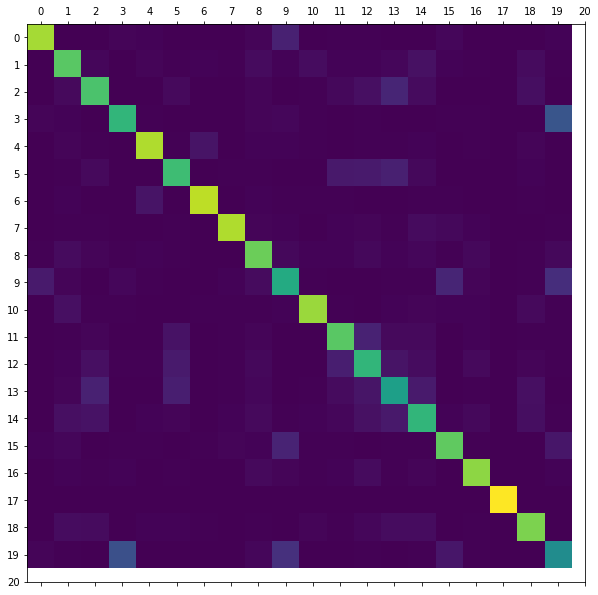

In [18]:
cm10 = random_cm(X, y, num_tests = 10)
plot_confusion_matrix(cm10)

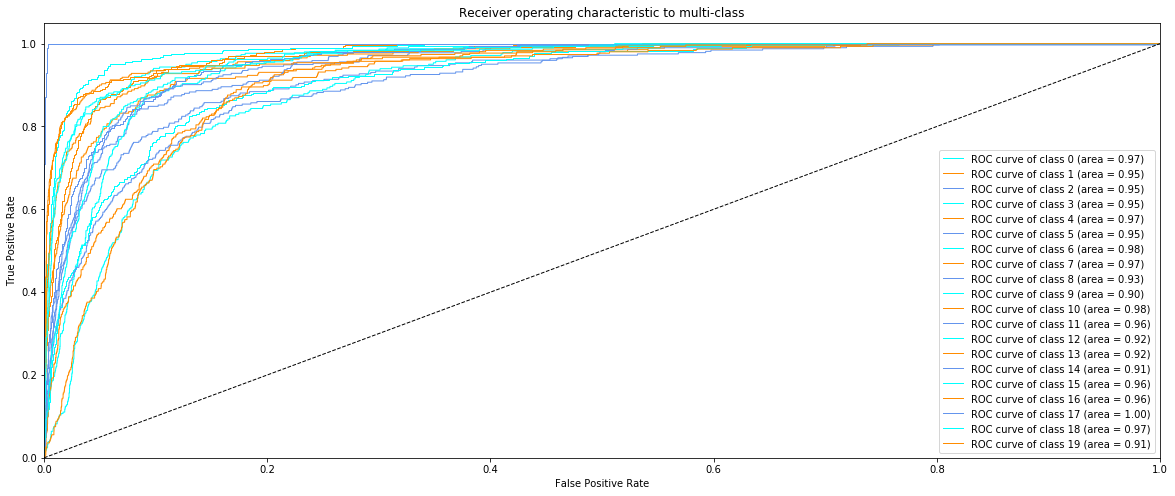

In [19]:
# Binarize the output
y_score = clf.decision_function(X_test)
y_test_bin = label_binarize(y_test, classes=range(20))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 20
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20,8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In order to better predict which class performed well a ROC-AUC curve was plotted. From the graph it was observed that **Class 17** was the best predicted class **"soc.religion.christian"**. This class performed better because it only had one parent class **'soc'** which led to better classification.

The worst performing class was found to be **Class = 9** which is **"talk.politics.misc"**. This class performed worst because it was wrongly classified to **Class = 15** which was **"talk.politics.guns"**. This can be attributed to the fact that the topic for both classes is same (politics) and the parent class is also a common class which is (talk). 



## Q2

### Q2 (a)

Modify the partial code below

In [0]:
def feature_num(X, y):
    # result_list is a list of tuples (num_features, train_accuracy, test_accuracy)
    # where numFeatures is the number of words used as features
    result_list = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for p in [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]:
        subset_size = int(p*X.shape[1])
        X_train_subset = X_train.iloc[:, 0:subset_size]
        X_test_subset = X_test.iloc[:, 0:subset_size]

        # Write your code here to calculate train_accuracy and test_accuracy for the current subset of features
        clf = LogisticRegression(C=1.0).fit(X_train_subset, y_train)
     
        # predict on train and test set
        y_train_predict = clf.predict(X_train_subset)
        y_test_predict = clf.predict(X_test_subset)
        
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)

        # add to result_list
        result_list.append((p, train_accuracy, test_accuracy))
        
    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["num_features", "train_accuracy", "test_accuracy"])
    
    # validate return type
    assert isinstance(result_df, pd.DataFrame), "return type"
    
    return result_df

### Q2 (b)

Use the following code to plot the train and test accuracy for the different feature sets sizes

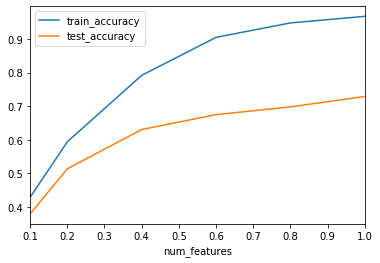

In [21]:
feature_num_df = feature_num(X, y)
feature_num_df.plot(x="num_features", y=["train_accuracy", "test_accuracy"])

From the above plot, it can be seen that the training and testing accuracy increases as the feature size is increased and the rate of increase in accuracy decreases as the features become less common.

## Q3

### Q3 (a)

Modify the partial code below

In [0]:
def hyperparameter(X, y):
    # result_list is a list of tuples (num_features, train_accuracy, test_accuracy)
    # where numFeatures is the number of words used as features
    result_list = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for param in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        # Write your code here to calculate train_accuracy and test_accuracy for the current parameter value

        clf = LogisticRegression(C=param).fit(X_train, y_train)

        # predict on train and test set
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)

        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)
        
        # add to result_list
        result_list.append((param, train_accuracy, test_accuracy))
        
    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["param", "train_accuracy", "test_accuracy"])
    
    # validate return type
    assert isinstance(result_df, pd.DataFrame), "return type"
    
    return result_df

### Q3 (b)

Use the following code to plot the train and test accuracy for the different the parameters

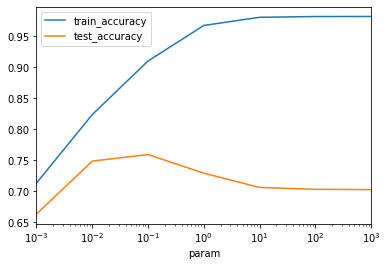

In [23]:
param_df = hyperparameter(X, y)
param_df.plot(x="param", y=["train_accuracy", "test_accuracy"], logx=True)

From the plot it is observed that the testing accuracy increases with the training accuracy when the hyperparameter reaches C = 0.1. After that point the testing accuracy decreases and the training accuracy keeps on increasing which suggests **overfitting**. Hence it is reccomended that the hyperparameter be set at C = 0.1.

## Q4

### Q4 (a)

Modify the partial code below

In [0]:
def tf_improved_data(file_list, num_words = 1000):
    # Put your code here
    # Make sure you update the variable features and targets below

    # Calculate word count in corpus
    news_cnt = corpus_count_clean_words(file_list)
    df_rows = []

    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    tokenizer = RegexpTokenizer(r'\w+')
    stop_words = set(stopwords.words('english'))
    lc = LancasterStemmer()
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            # converting all thw words into lowercase
            file_words = [word.lower() for word in file_words] 
            # stemming and removing stopwords from the list of lowercase words.
            file_words = [lc.stem(x) for x in file_words if x not in stop_words]
            #removing numbers using regex
            new_list = []
            for word in file_words:
              word = re.sub(r'^[\d-]+ ','',word)
              if word != '':
                new_list.append(word)
            word_count = Counter(new_list)
            df_rows.append([word_count[word] for word in word_list])      

    X = pd.DataFrame(df_rows, columns = word_list)

    # Create a dataframe of targets (y)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    
    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

### Q4 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [25]:
X_tf, y_tf = tf_improved_data(all_files)
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X_tf, y_tf, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.9516324926770021
Train confidence interval over 10 random splits: [0.9471906463903231, 0.9560743389636811]
Test mean accuracy over 10 random splits: 0.7386166666666667
Test confidence interval over 10 random splits: [0.7346563758378992, 0.7425769574954342]


From the above results it is evident that binary encoding performed a little better that TF encoding. This can be attributted the fact that higher term frequency leads to more weight when determining the class due to which less frequent terms does not at all or play a very small role.

## Q5

### Q5 (a)

Modify the partial code below

In [0]:
def nb_random_mean_ci(X, y, num_tests):
    # train_results is a list of train accuracy results for the differrent random splits of the dataset
    train_results = []
    
    # test_results is a list of test accuracy results for the differrent random splits of the dataset
    test_results = []
    
    # Write your code here
    for i in range(num_tests):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.randint(1,1000))

      #train a multinomial Naive Bayes classifier
      nb = MultinomialNB().fit(X_train, y_train)

      # predict on train and test set
      y_train_predict = nb.predict(X_train)
      y_test_predict = nb.predict(X_test) 

      # calculate train and test accuracy
      train_accuracy = accuracy_score(y_train, y_train_predict)
      test_accuracy = accuracy_score(y_test, y_test_predict)

      #appending the accuracy results to the empty lists
      train_results.append(train_accuracy)
      test_results.append(test_accuracy)

    # calculate the train mean and the 95% confidence interval for the list of results
    train_mean = np.mean(train_results)
    train_ci_low, train_ci_high = stats.t.interval(0.95, len(train_results)-1, loc=train_mean, scale=stats.sem(train_results))
    
    # calculate the test mean and the 95% confidence interval for the list of results
    test_mean = np.mean(test_results)
    test_ci_low, test_ci_high = stats.t.interval(0.95, len(test_results)-1, loc=test_mean, scale=stats.sem(test_results))
    
    # validate return types
    assert isinstance(train_mean, float) and isinstance(train_ci_low, float) and isinstance(train_ci_high, float), "return types"
    assert isinstance(test_mean, float) and isinstance(test_ci_low, float) and isinstance(test_ci_high, float), "return types"
    
    return train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high

### Q5 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [27]:
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = nb_random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.7832321211688219
Train confidence interval over 10 random splits: [0.7815313471721125, 0.7849328951655313]
Test mean accuracy over 10 random splits: 0.7368666666666666
Test confidence interval over 10 random splits: [0.7342486336497527, 0.7394846996835804]


From the above results it can be seen that Logistic Regression performed much better than Naive Bayes. This is beacuse of the fact that naive bayes assumes that features are conditionally independent. So if there are no occurences of a class label along with a certain attribute than the frequency based probability estimates are zero. https://www.saedsayad.com/naive_bayesian.htm 

## Q6

### Q6 (a)

Modify the partial code below

In [0]:
def binary_med_data(file_list, num_words = 1000):
    
    # Calculate word count in corpus
    news_cnt = corpus_count_clean_words(file_list)
    df_rows = []
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    tokenizer = RegexpTokenizer(r'\w+')
    stop_words = set(stopwords.words('english'))
    lc = LancasterStemmer()
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            # converting all thw words into lowercase
            file_words = [word.lower() for word in file_words] 
            # stemming and removing stopwords from the list of lowercase words.
            file_words = [lc.stem(x) for x in file_words if x not in stop_words]
            #removing numbers using regex
            new_list = []
            for word in file_words:
              word = re.sub(r'^[\d-]+ ','',word)
              if word != '':
                new_list.append(word)
            df_rows.append([1 if word in new_list else 0 for word in word_list])      

    X = pd.DataFrame(df_rows, columns = word_list)

    # Create a dataframe of targets (y)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    y = [1 if target_topic == 8 else 0 for target_topic in y]

    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

### Q6 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [29]:
X, y = binary_med_data(all_files)
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.9920054297349432
Train confidence interval over 10 random splits: [0.9917168725909209, 0.9922939868789655]
Test mean accuracy over 10 random splits: 0.9735333333333334
Test confidence interval over 10 random splits: [0.9722907347175916, 0.9747759319490751]


**Average:** This is the mean of 10 testing and 10 training accuracies obtained during the random split.

**95% CI:** The confidence interval is defined as the intervals for the average accuracy that should hold 95 out of 100 times when the experiment is run randomly.

**Comparison to MultiClass Logistic Regression:** From the above results it is seen that the average accuracy of binary logistic regression was foiund to be higher than multiclass logistic regression and had a lower variance in the results. This is the case becuase multiclass logistic regression deals with classifying multiple classes whereas binary logistic regression is based on whether a label belongs to a particlar class or not.